In [2]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils.data import DataLoader
import torchvision, numpy as np

In [3]:
batch_size = 64 if torch.cuda.is_available() else 16

### datasets and dataloaders

In [4]:

transforms = tfs.Compose([
    tfs.RandomCrop(32, padding=4),    
    tfs.RandomHorizontalFlip(),         
    tfs.ToTensor(),
    tfs.Normalize((0.4914, 0.4822, 0.4465),
                  (0.247, 0.2435, 0.2616))
])


train_data = datasets.CIFAR10(
    root='F:\KOSOSHER\my-shits-in-ai\data',
    download=True,
    train=True,
    transform=transforms,
)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


test_data = datasets.CIFAR10(
    root='F:\KOSOSHER\my-shits-in-ai\data',
    download=True,
    train=False,
    transform=transforms,
)

test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

<>:11: SyntaxWarning: invalid escape sequence '\K'
<>:21: SyntaxWarning: invalid escape sequence '\K'
<>:11: SyntaxWarning: invalid escape sequence '\K'
<>:21: SyntaxWarning: invalid escape sequence '\K'
C:\Users\ahmad\AppData\Local\Temp\ipykernel_20196\618654969.py:11: SyntaxWarning: invalid escape sequence '\K'
  root='F:\KOSOSHER\my-shits-in-ai\data',
C:\Users\ahmad\AppData\Local\Temp\ipykernel_20196\618654969.py:21: SyntaxWarning: invalid escape sequence '\K'
  root='F:\KOSOSHER\my-shits-in-ai\data',


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.5632443].


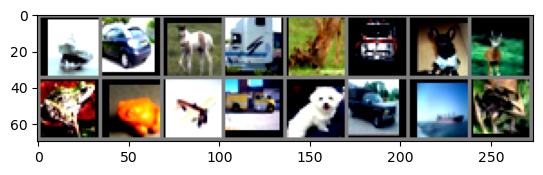

ship  car   horse truck deer  truck dog   deer  frog  frog  plane truck dog   truck ship  frog 


In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# functions for showing an image :
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_dataloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


### Residual Blocks and Residual Networks

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

In [7]:
class ResNet_CIFAR10(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet_CIFAR10, self).__init__()
        self.in_channels = 16 # Often starts with 16 channels for CIFAR10

        # Modified initial convolutional layer for CIFAR-10
        # Smaller kernel, stride 1, no max pooling immediately
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        # self.maxpool is typically removed for CIFAR-10 specific ResNets

        # The layers define the channel progression and number of blocks
        # For CIFAR-10, common output channels are 16, 32, 64
        self.layer1 = self._make_layer(block, 16, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2) # Downsample here
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2) # Downsample here
        # For some CIFAR-10 ResNets, only 3 stages are used,
        # or the last stage might have more channels but typically
        # max 64 channels in the last block output before FC.

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # The final FC layer input size will depend on the last layer's output channels
        # If last layer outputs 64 channels, then:
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []
        # The first block in the layer can have stride for downsampling
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
model = ResNet_CIFAR10(ResidualBlock, [3, 3, 3])
model = model.to(device)

In [10]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [30]:
def train_set(model, data_loader, loss_fn, optim, device):
    running_loss, correct = 0.0, 0
    model.train()
    for batch_idx, (x, y) in enumerate(data_loader):
        # print(f"Batch {batch_idx}")  # Debug line
        x, y = x.to(device), y.to(device)
        optim.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optim.step()
        running_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float64).sum().item()
    return running_loss / len(data_loader), (correct / len(data_loader.dataset)) * 100

In [31]:
def train_data(model, data_loader, loss_fn, optim, device, epochs):
    training_losses, training_accs = [], []
    for epoch in range(1, epochs + 1):
        # print(f"hello {epoch}")
        train_loss, train_acc = train_set(model, data_loader, loss_fn, optim, device)
        print(f"Epoch {epoch} / {epochs} => loss : {train_loss:.3f} ; accuracy : {train_acc:.3f} ")
        training_losses.append(train_loss)
        training_accs.append(train_acc)
    return training_losses, training_accs

In [32]:
train_data(model, train_dataloader, loss_fn, optim, device, 10)

Epoch 1 / 10 => loss : 1.092 ; accuracy : 60.994 
Epoch 2 / 10 => loss : 0.904 ; accuracy : 68.278 
Epoch 3 / 10 => loss : 0.782 ; accuracy : 72.808 
Epoch 4 / 10 => loss : 0.710 ; accuracy : 75.312 
Epoch 5 / 10 => loss : 0.656 ; accuracy : 77.466 


KeyboardInterrupt: 